In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding
from sklearn.metrics import r2_score, root_mean_squared_error as rmse
from time import time
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern
from sklearn.inspection import permutation_importance

## Data Preprocessing

In [2]:
# https://www.kaggle.com/datasets/pooriamst/metro-interstate-traffic-volume
src = r"C:\Users\Abdel Jalal\Documents\AI 221\datasets\Metro_Interstate_Traffic_Volume.csv"

In [3]:
metro_df = pd.read_csv(src, nrows=15000)
display(metro_df)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.00,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.00,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.00,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
14995,NaN,286.13,0.00,0.0,36,Clouds,scattered clouds,2014-06-07 22:00:00,3269
14996,NaN,285.10,0.51,0.0,1,Rain,light rain,2014-06-07 23:00:00,2534
14997,NaN,285.10,0.51,0.0,1,Mist,mist,2014-06-07 23:00:00,2534
14998,NaN,284.51,0.51,0.0,0,Rain,light rain,2014-06-08 00:00:00,1748


print(metro_df.info())

In [4]:
print(metro_df['holiday'].value_counts())

holiday
Columbus Day                 2
Veterans Day                 2
Thanksgiving Day             2
Christmas Day                2
New Years Day                2
Washingtons Birthday         2
Memorial Day                 2
Independence Day             1
State Fair                   1
Labor Day                    1
Martin Luther King Jr Day    1
Name: count, dtype: int64


In [5]:
for idx, val in metro_df['holiday'].items():
    if pd.isna(val) == True:
        metro_df.loc[idx, 'holiday'] = 0
    else:
        metro_df.loc[idx, 'holiday'] = 1

print(metro_df['holiday'].value_counts())

holiday
0    14982
1       18
Name: count, dtype: int64


In [6]:
metro_df['weather_main'] = metro_df['weather_main'].str.lower()
print(metro_df['weather_main'].value_counts())

weather_main
clouds          6209
clear           3449
rain            1665
mist            1663
snow             950
haze             356
drizzle          351
fog              189
thunderstorm     165
squall             3
Name: count, dtype: int64


In [7]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
weather_main_encoded = encoder.fit_transform(metro_df[['weather_main']])
weather_main_df = pd.DataFrame(weather_main_encoded, columns=encoder.get_feature_names_out(['weather_main']), index=metro_df.index)

metro_df = pd.concat([metro_df, weather_main_df], axis=1)
metro_df.drop(columns=['weather_main'], inplace=True)

In [8]:
metro_df['date_time'] = pd.to_datetime(metro_df['date_time'])
# metro_df['date'] = metro_df['date_time'].dt.date
# metro_df['time'] = metro_df['date_time'].dt.time

metro_df['year'] = metro_df['date_time'].dt.year
metro_df['month'] = metro_df['date_time'].dt.month
metro_df['day'] = metro_df['date_time'].dt.day
metro_df['hour'] = metro_df['date_time'].dt.hour
metro_df['minute'] = metro_df['date_time'].dt.minute

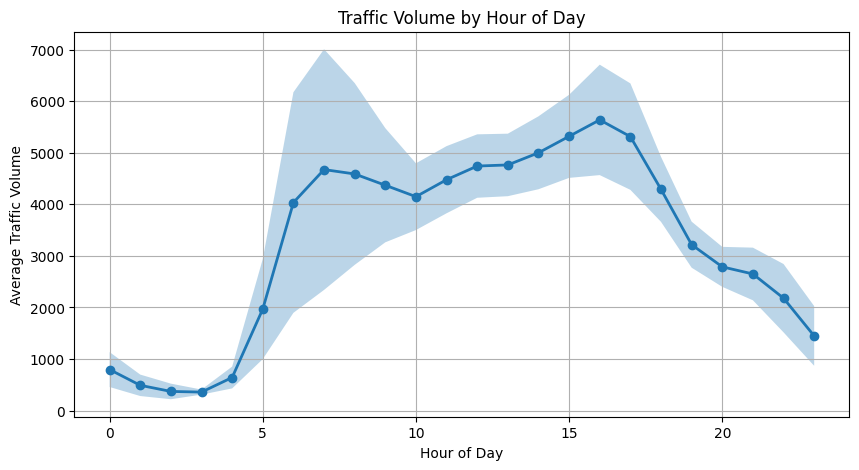

In [9]:
hourly_avg = metro_df.groupby('hour')['traffic_volume'].agg(['mean', 'std'])
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg['mean'], marker='o', linewidth=2)
plt.fill_between(hourly_avg.index, 
                 hourly_avg['mean'] - hourly_avg['std'],
                 hourly_avg['mean'] + hourly_avg['std'], alpha=0.3)
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.title('Traffic Volume by Hour of Day')
plt.grid()
plt.show()

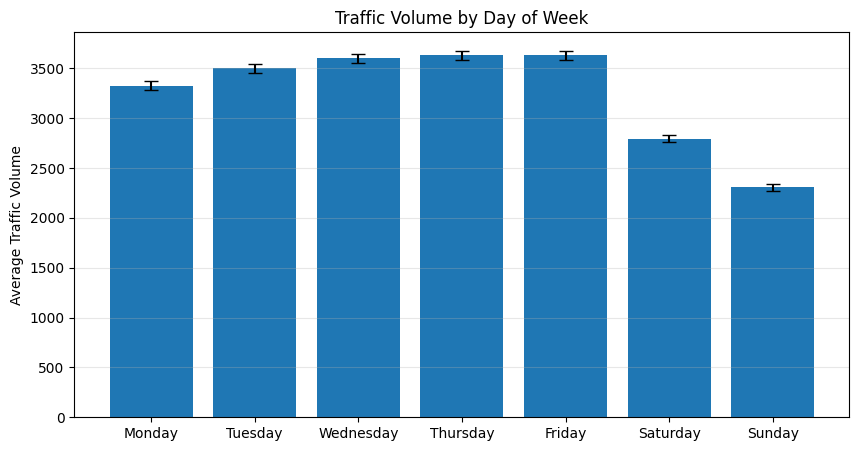

In [13]:
metro_df['day_of_week'] = metro_df['date_time'].dt.dayofweek

grouped = metro_df.groupby('day_of_week')['traffic_volume']
daily_avg = grouped.mean()
daily_sem = grouped.sem()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
plt.bar(
    range(7),
    daily_avg.values,
    yerr=daily_sem.values,
    capsize=5
)
plt.xticks(range(7), days)
plt.ylabel('Average Traffic Volume')
plt.title('Traffic Volume by Day of Week')
plt.grid(axis='y', alpha=0.3)
plt.show()

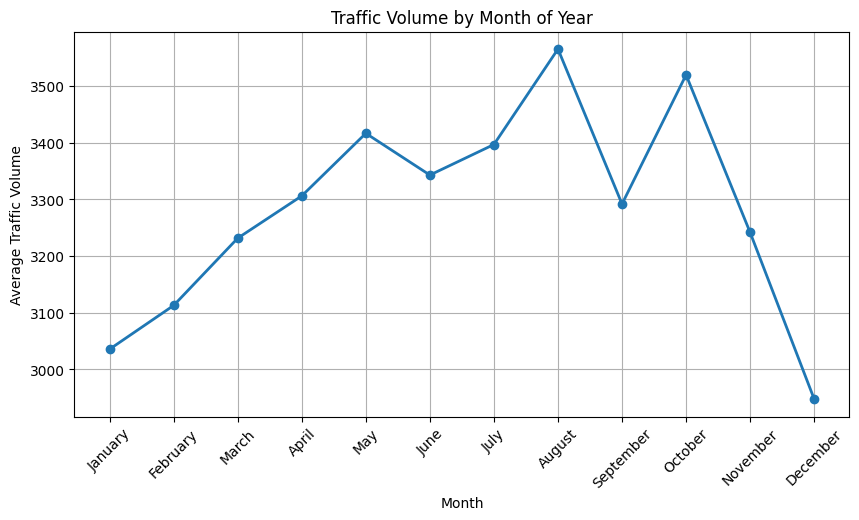

In [14]:
monthly_avg = metro_df.groupby('month')['traffic_volume'].mean()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
plt.xticks(ticks=np.arange(12)+1, labels=months, rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Traffic Volume')
plt.title('Traffic Volume by Month of Year')
plt.grid()
plt.show()

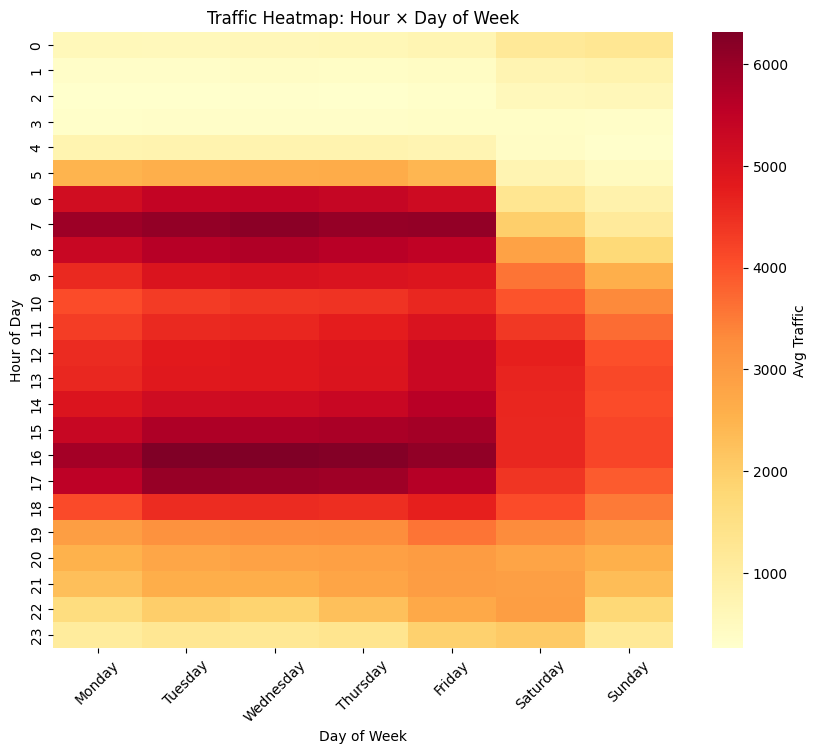

In [15]:
metro_df['day_of_week'] = metro_df['date_time'].dt.dayofweek
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = metro_df.pivot_table(values='traffic_volume', 
                             index='hour', 
                             columns='day_of_week', 
                             aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'Avg Traffic'})
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.xticks(ticks=np.arange(7)+0.5, labels=days, rotation=45)
plt.title('Traffic Heatmap: Hour × Day of Week')
plt.show()

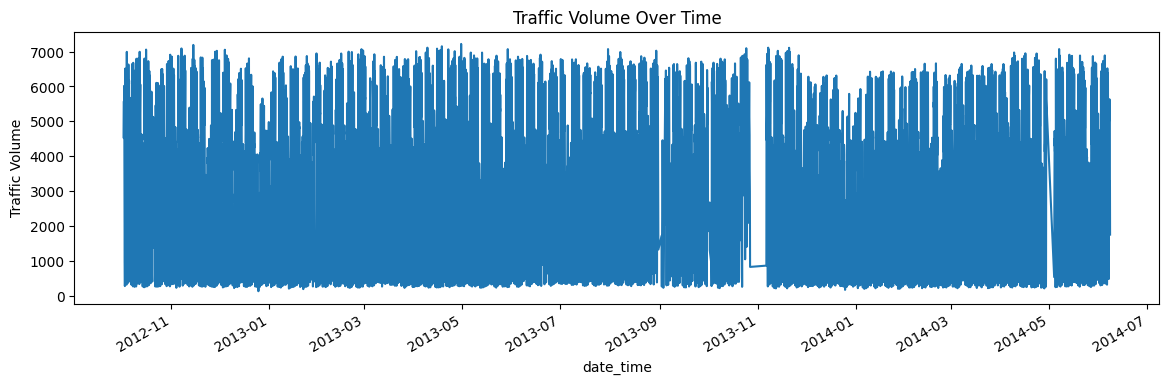

In [ ]:
metro_df_viz = metro_df.copy()
metro_df_viz.set_index('date_time', inplace=True)
metro_df_viz['traffic_volume'].plot(figsize=(14, 4))
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Over Time')
plt.show()

In [12]:
metro_df['weather_description'] = metro_df['weather_description'].str.lower()
print(metro_df['weather_description'].value_counts())

weather_description
sky is clear                           3449
overcast clouds                        2241
broken clouds                          2143
mist                                   1663
light rain                             1171
scattered clouds                        959
few clouds                              866
heavy snow                              574
moderate rain                           388
haze                                    356
light snow                              277
light intensity drizzle                 229
fog                                     189
drizzle                                 111
snow                                     95
heavy intensity rain                     93
proximity thunderstorm                   92
thunderstorm with heavy rain             19
thunderstorm                             17
thunderstorm with light rain             17
heavy intensity drizzle                  11
proximity thunderstorm with rain         10
very heavy r

In [13]:
metro_df = metro_df.drop(columns=['date_time','weather_description','minute'])

In [14]:
scaler = StandardScaler()

metro_df['temp'] = scaler.fit_transform(metro_df[['temp']])
metro_df['rain_1h'] = scaler.fit_transform(metro_df[['rain_1h']])
metro_df['snow_1h'] = scaler.fit_transform(metro_df[['snow_1h']])
metro_df['clouds_all'] = scaler.fit_transform(metro_df[['clouds_all']])
metro_df['year'] = scaler.fit_transform(metro_df[['year']])
metro_df['month'] = scaler.fit_transform(metro_df[['month']])
metro_df['day'] = scaler.fit_transform(metro_df[['day']])
metro_df['hour'] = scaler.fit_transform(metro_df[['hour']])

In [15]:
display(metro_df)

,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weather_main_clear,weather_main_clouds,weather_main_drizzle,weather_main_fog,...,weather_main_mist,weather_main_rain,weather_main_snow,weather_main_squall,weather_main_thunderstorm,year,month,day,hour,day_of_week
0,0,0.795281,-0.129060,0.0,-0.388084,5545,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.675991,1.000041,-1.569542,-0.358739,1
1,0,0.868799,-0.129060,0.0,0.558260,4516,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.675991,1.000041,-1.569542,-0.214567,1
2,0,0.883775,-0.129060,0.0,0.963835,4767,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.675991,1.000041,-1.569542,-0.070395,1
3,0,0.921214,-0.129060,0.0,0.963835,5026,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.675991,1.000041,-1.569542,0.073778,1
4,0,0.989967,-0.129060,0.0,0.558260,4918,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.675991,1.000041,-1.569542,0.217950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0.648927,-0.129060,0.0,-0.496237,3269,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.406953,-0.073291,-0.988359,1.515500,5
14996,0,0.578813,0.302107,0.0,-1.442581,2534,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.406953,-0.073291,-0.988359,1.659673,5
14997,0,0.578813,0.302107,0.0,-1.442581,2534,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.406953,-0.073291,-0.988359,1.659673,5
14998,0,0.538650,0.302107,0.0,-1.469619,1748,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.406953,-0.073291,-0.872123,-1.656289,6


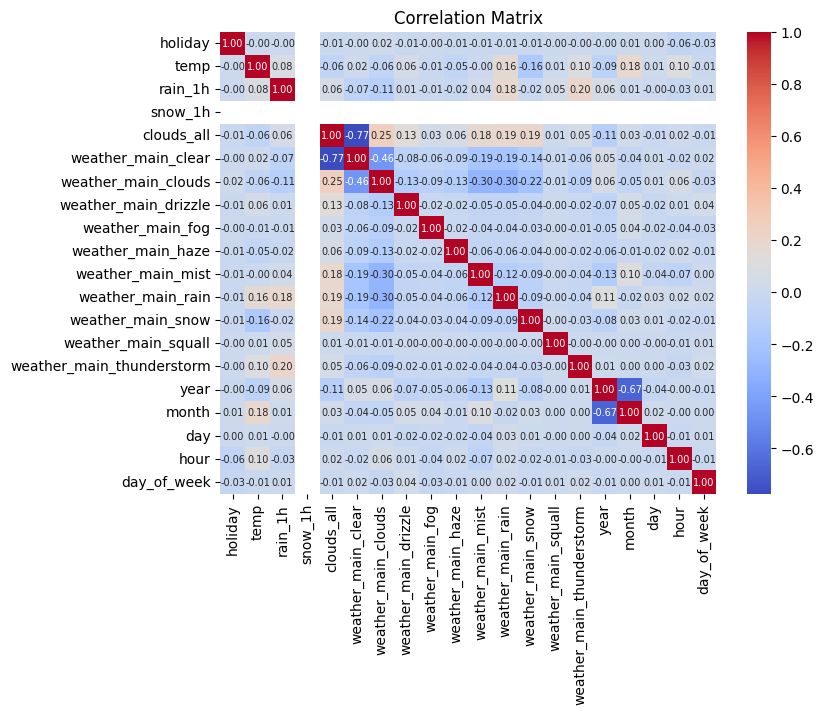

In [16]:
correlation_matrix = metro_df.drop('traffic_volume', axis=1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    annot_kws={"size": 7},
    cmap='coolwarm',
    fmt=".2f"
)

plt.title('Correlation Matrix')
plt.show()

In [17]:
x = metro_df.drop('traffic_volume', axis=1)
y = metro_df['traffic_volume']

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Models

### SVM

In [29]:
# SVM

model_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.01, 1, 100]}

pipeline = SVR()

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4] END .............C=0.01, kernel=linear;, score=0.002 total time=   0.1s
[CV 2/4] END .............C=0.01, kernel=linear;, score=0.003 total time=   0.5s
[CV 3/4] END .............C=0.01, kernel=linear;, score=0.005 total time=   1.4s
[CV 4/4] END .............C=0.01, kernel=linear;, score=0.007 total time=   2.2s
[CV 1/4] END ..............C=0.01, kernel=poly;, score=-0.025 total time=   0.1s
[CV 2/4] END ...............C=0.01, kernel=poly;, score=0.000 total time=   0.6s
[CV 3/4] END ..............C=0.01, kernel=poly;, score=-0.000 total time=   1.5s
[CV 4/4] END ..............C=0.01, kernel=poly;, score=-0.001 total time=   2.6s
[CV 1/4] END ...............C=0.01, kernel=rbf;, score=-0.000 total time=   0.4s
[CV 2/4] END ...............C=0.01, kernel=rbf;, score=-0.001 total time=   1.4s
[CV 3/4] END ...............C=0.01, kernel=rbf;, score=-0.002 total time=   2.6s
[CV 4/4] END ...............C=0.01, kernel=rbf;,

In [30]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.64560
Runtime: 92.2149 sec
R-squared of test data: 0.66877
Runtime: 93.3478 sec


In [14]:
# SVM + PCA

model_params = {'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'svr__C': [0.01, 1, 100]}

pipeline = make_pipeline(PCA(), SVR())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.002 total time=   0.1s
[CV 2/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.003 total time=   0.5s
[CV 3/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.005 total time=   1.2s
[CV 4/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.007 total time=   2.1s
[CV 1/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.031 total time=   0.1s
[CV 2/4] END .....svr__C=0.01, svr__kernel=poly;, score=0.000 total time=   0.6s
[CV 3/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.000 total time=   1.4s
[CV 4/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.001 total time=   2.6s
[CV 1/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.000 total time=   0.4s
[CV 2/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.001 total time=   1.3s
[CV 3/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.002 total time=   2.7s
[CV 4/4] END .....svr__C=0.01, svr__kernel=rbf;,

In [15]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.64607
Runtime: 90.6924 sec
R-squared of test data: 0.66914
Runtime: 91.7416 sec


In [16]:
# SVM + KPCA

model_params = {'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'svr__C': [0.01, 1, 100]}

pipeline = make_pipeline(KernelPCA(), SVR())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.002 total time=   1.5s
[CV 2/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.003 total time=  15.6s
[CV 3/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.005 total time=  54.4s
[CV 4/4] END ...svr__C=0.01, svr__kernel=linear;, score=0.007 total time= 2.0min
[CV 1/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.031 total time=   1.9s
[CV 2/4] END .....svr__C=0.01, svr__kernel=poly;, score=0.000 total time=  15.0s
[CV 3/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.000 total time=  49.9s
[CV 4/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.001 total time= 1.9min
[CV 1/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.000 total time=   3.0s
[CV 2/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.001 total time=  15.8s
[CV 3/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.002 total time=  50.3s
[CV 4/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.000 total time= 2.0min
[CV 1/4] END .svr__C=0.01, s

In [17]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.64607
Runtime: 2497.3626 sec
R-squared of test data: 0.66914
Runtime: 2499.0470 sec


In [18]:
# SVM + LLE

model_params = {'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'svr__C': [0.01, 1, 100]}

pipeline = make_pipeline(LocallyLinearEmbedding(), SVR())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.001 total time=   3.9s
[CV 2/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.001 total time=   1.2s
[CV 3/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.002 total time=   2.1s
[CV 4/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.001 total time=   3.2s
[CV 1/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.001 total time=   0.4s
[CV 2/4] END .....svr__C=0.01, svr__kernel=poly;, score=0.001 total time=   0.9s
[CV 3/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.001 total time=   2.2s
[CV 4/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.002 total time=   3.3s
[CV 1/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.001 total time=   0.8s
[CV 2/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.001 total time=   2.4s
[CV 3/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.002 total time=   3.0s
[CV 4/4] END .....svr__C=0.01, svr__kernel=rbf;,

In [19]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: -0.00111
Runtime: 117.9357 sec
R-squared of test data: -0.00543
Runtime: 118.2467 sec


In [20]:
# SVM + Isomap

model_params = {'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'svr__C': [0.01, 1, 100]}

pipeline = make_pipeline(Isomap(), SVR())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.001 total time=   1.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.002 total time=   4.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.002 total time=  11.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ..svr__C=0.01, svr__kernel=linear;, score=-0.000 total time=  20.3s
[CV 1/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.000 total time=   1.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.001 total time=   4.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.002 total time=  11.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ....svr__C=0.01, svr__kernel=poly;, score=-0.001 total time=  19.6s
[CV 1/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.001 total time=   1.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.001 total time=   5.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.002 total time=  12.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .....svr__C=0.01, svr__kernel=rbf;, score=-0.001 total time=  22.4s
[CV 1/4] END .svr__C=0.01, svr__kernel=sigmoid;, score=-0.001 total time=   1.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .svr__C=0.01, svr__kernel=sigmoid;, score=-0.001 total time=   5.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .svr__C=0.01, svr__kernel=sigmoid;, score=-0.002 total time=  12.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .svr__C=0.01, svr__kernel=sigmoid;, score=-0.001 total time=  21.2s
[CV 1/4] END .....svr__C=1, svr__kernel=linear;, score=-0.013 total time=   1.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .....svr__C=1, svr__kernel=linear;, score=-0.002 total time=   4.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .....svr__C=1, svr__kernel=linear;, score=-0.004 total time=  10.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .....svr__C=1, svr__kernel=linear;, score=-0.002 total time=  20.3s
[CV 1/4] END .......svr__C=1, svr__kernel=poly;, score=-0.002 total time=   1.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .......svr__C=1, svr__kernel=poly;, score=-0.000 total time=   4.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .......svr__C=1, svr__kernel=poly;, score=-0.003 total time=  11.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .......svr__C=1, svr__kernel=poly;, score=-0.000 total time=  19.2s
[CV 1/4] END ........svr__C=1, svr__kernel=rbf;, score=-0.000 total time=   1.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ........svr__C=1, svr__kernel=rbf;, score=-0.001 total time=   5.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .........svr__C=1, svr__kernel=rbf;, score=0.001 total time=  13.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .........svr__C=1, svr__kernel=rbf;, score=0.002 total time=  22.8s
[CV 1/4] END ....svr__C=1, svr__kernel=sigmoid;, score=-0.001 total time=   1.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ....svr__C=1, svr__kernel=sigmoid;, score=-0.002 total time=   5.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ....svr__C=1, svr__kernel=sigmoid;, score=-0.002 total time=  12.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ....svr__C=1, svr__kernel=sigmoid;, score=-0.000 total time=  22.0s
[CV 1/4] END ...svr__C=100, svr__kernel=linear;, score=-0.015 total time=   1.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ...svr__C=100, svr__kernel=linear;, score=-0.002 total time=   5.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ...svr__C=100, svr__kernel=linear;, score=-0.004 total time=  11.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ...svr__C=100, svr__kernel=linear;, score=-0.002 total time=  21.3s
[CV 1/4] END .....svr__C=100, svr__kernel=poly;, score=-0.013 total time=   1.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .....svr__C=100, svr__kernel=poly;, score=-0.002 total time=   4.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .....svr__C=100, svr__kernel=poly;, score=-0.003 total time=  11.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .....svr__C=100, svr__kernel=poly;, score=-0.001 total time=  20.5s
[CV 1/4] END ......svr__C=100, svr__kernel=rbf;, score=-0.006 total time=   1.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .......svr__C=100, svr__kernel=rbf;, score=0.006 total time=   5.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .......svr__C=100, svr__kernel=rbf;, score=0.023 total time=  13.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .......svr__C=100, svr__kernel=rbf;, score=0.020 total time=  22.6s
[CV 1/4] END ..svr__C=100, svr__kernel=sigmoid;, score=-7.612 total time=   1.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .svr__C=100, svr__kernel=sigmoid;, score=-16.272 total time=   5.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .svr__C=100, svr__kernel=sigmoid;, score=-54.083 total time=  12.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END svr__C=100, svr__kernel=sigmoid;, score=-116.602 total time=  22.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing th

RandomizedSearchCV took 518.44 seconds for 50 candidates parameter settings.
{'svr__kernel': 'rbf', 'svr__C': 100}
Pipeline(steps=[('isomap', Isomap()), ('svr', SVR(C=100))])


In [21]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.00887
Runtime: 520.3350 sec
R-squared of test data: 0.02089
Runtime: 522.2511 sec


### Linear Regression

In [31]:
# Linear Regression

model_params = {'alpha': [0.1, 1, 10],
                'solver': ['auto','svd','lbfgs']}

pipeline = Ridge()

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END ............alpha=0.1, solver=auto;, score=0.152 total time=   0.0s
[CV 2/4] END ............alpha=0.1, solver=auto;, score=0.127 total time=   0.0s
[CV 3/4] END ............alpha=0.1, solver=auto;, score=0.149 total time=   0.0s
[CV 4/4] END ............alpha=0.1, solver=auto;, score=0.128 total time=   0.0s
[CV 1/4] END .............alpha=0.1, solver=svd;, score=0.152 total time=   0.0s
[CV 2/4] END .............alpha=0.1, solver=svd;, score=0.127 total time=   0.0s
[CV 3/4] END .............alpha=0.1, solver=svd;, score=0.149 total time=   0.0s
[CV 4/4] END .............alpha=0.1, solver=svd;, score=0.128 total time=   0.0s
[CV 1/4] END .............alpha=0.1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/4] END .............alpha=0.1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/4] END .............alpha=0.1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/4] END .............alpha=0.1, solver=lbfgs

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

In [32]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.15040
Runtime: 3.7789 sec
R-squared of test data: 0.13294
Runtime: 3.7807 sec


In [22]:
# Linear Regression + PCA

model_params = {'ridge__alpha': [0.1, 1, 10],
                'ridge__solver': ['auto','svd','lbfgs']}

pipeline = make_pipeline(PCA(), Ridge())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.152 total time=   0.0s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.127 total time=   0.0s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.149 total time=   0.0s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.128 total time=   0.0s
[CV 1/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.152 total time=   0.0s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.127 total time=   0.0s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.149 total time=   0.0s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.128 total time=   0.0s
[CV 1/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.0s
[CV 1/4] END

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

In [23]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.15040
Runtime: 1.0478 sec
R-squared of test data: 0.13294
Runtime: 1.0478 sec


In [24]:
# Linear Regression + KPCA

model_params = {'ridge__alpha': [0.1, 1, 10],
                'ridge__solver': ['auto','svd','lbfgs']}

pipeline = make_pipeline(KernelPCA(), Ridge())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.152 total time=   1.5s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.127 total time=  14.2s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.149 total time=  52.3s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.128 total time= 1.9min
[CV 1/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.152 total time=   1.6s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.127 total time=  14.5s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.149 total time=  47.4s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.128 total time= 1.8min
[CV 1/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   1.5s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=  13.3s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=  46.1s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time= 1.8min
[CV 1/4] END

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

RandomizedSearchCV took 1747.91 seconds for 50 candidates parameter settings.
{'ridge__solver': 'auto', 'ridge__alpha': 0.1}
Pipeline(steps=[('kernelpca', KernelPCA()), ('ridge', Ridge(alpha=0.1))])


In [25]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.15040
Runtime: 1748.3485 sec
R-squared of test data: 0.13294
Runtime: 1748.5608 sec


In [26]:
# Linear Regression + LLE

model_params = {'ridge__alpha': [0.1, 1, 10],
                'ridge__solver': ['auto','svd','lbfgs']}

pipeline = make_pipeline(LocallyLinearEmbedding(), Ridge())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.001 total time=   0.5s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.003 total time=   0.5s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.002 total time=   1.0s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.000 total time=   1.6s
[CV 1/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.001 total time=   0.3s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.002 total time=   0.6s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.001 total time=   1.1s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.000 total time=   1.4s
[CV 1/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.1s
[CV 2/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.5s
[CV 3/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.8s
[CV 4/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   1.2s
[CV 1/4] END

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

RandomizedSearchCV took 30.36 seconds for 50 candidates parameter settings.
{'ridge__solver': 'auto', 'ridge__alpha': 0.1}
Pipeline(steps=[('locallylinearembedding', LocallyLinearEmbedding()),
                ('ridge', Ridge(alpha=0.1))])


In [27]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.00065
Runtime: 30.5856 sec
R-squared of test data: -0.00256
Runtime: 30.8695 sec


In [28]:
# Linear Regression + Isomap

model_params = {'ridge__alpha': [0.1, 1, 10],
                'ridge__solver': ['auto','svd','lbfgs']}

pipeline = make_pipeline(Isomap(), Ridge())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/4] END ridge__alpha=0.1, ridge__solver=auto;, score=-0.006 total time=   1.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.000 total time=   7.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.000 total time=  17.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ridge__alpha=0.1, ridge__solver=auto;, score=0.001 total time=  28.0s
[CV 1/4] END ridge__alpha=0.1, ridge__solver=svd;, score=-0.006 total time=   1.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.000 total time=   4.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.000 total time=  10.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ridge__alpha=0.1, ridge__solver=svd;, score=0.001 total time=  18.6s
[CV 1/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   0.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   3.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=   9.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ridge__alpha=0.1, ridge__solver=lbfgs;, score=nan total time=  24.0s
[CV 1/4] END ridge__alpha=1, ridge__solver=auto;, score=-0.006 total time=   2.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ridge__alpha=1, ridge__solver=auto;, score=0.000 total time=   7.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ridge__alpha=1, ridge__solver=auto;, score=0.000 total time=  11.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ridge__alpha=1, ridge__solver=auto;, score=0.001 total time=  18.7s
[CV 1/4] END ridge__alpha=1, ridge__solver=svd;, score=-0.006 total time=   1.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .ridge__alpha=1, ridge__solver=svd;, score=0.000 total time=   3.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .ridge__alpha=1, ridge__solver=svd;, score=0.000 total time=   9.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .ridge__alpha=1, ridge__solver=svd;, score=0.001 total time=  20.5s
[CV 1/4] END .ridge__alpha=1, ridge__solver=lbfgs;, score=nan total time=   1.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END .ridge__alpha=1, ridge__solver=lbfgs;, score=nan total time=   5.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END .ridge__alpha=1, ridge__solver=lbfgs;, score=nan total time=  11.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END .ridge__alpha=1, ridge__solver=lbfgs;, score=nan total time=  20.6s
[CV 1/4] END ridge__alpha=10, ridge__solver=auto;, score=-0.006 total time=   1.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ridge__alpha=10, ridge__solver=auto;, score=0.000 total time=   4.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ridge__alpha=10, ridge__solver=auto;, score=0.000 total time=  10.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ridge__alpha=10, ridge__solver=auto;, score=0.001 total time=  19.9s
[CV 1/4] END ridge__alpha=10, ridge__solver=svd;, score=-0.006 total time=   1.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ridge__alpha=10, ridge__solver=svd;, score=0.000 total time=   4.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ridge__alpha=10, ridge__solver=svd;, score=0.000 total time=  10.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ridge__alpha=10, ridge__solver=svd;, score=0.001 total time=  19.2s
[CV 1/4] END ridge__alpha=10, ridge__solver=lbfgs;, score=nan total time=   0.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END ridge__alpha=10, ridge__solver=lbfgs;, score=nan total time=   4.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END ridge__alpha=10, ridge__solver=lbfgs;, score=nan total time=   9.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END ridge__alpha=10, ridge__solver=lbfgs;, score=nan total time=  23.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

RandomizedSearchCV took 388.15 seconds for 50 candidates parameter settings.
{'ridge__solver': 'svd', 'ridge__alpha': 10}
Pipeline(steps=[('isomap', Isomap()), ('ridge', Ridge(alpha=10, solver='svd'))])


In [29]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: -0.00282
Runtime: 388.8682 sec
R-squared of test data: -0.00292
Runtime: 389.4498 sec


### GPR

In [33]:
# GPR

model_params = {'kernel': [RBF(), ExpSineSquared(), Matern()],
                'alpha': [1e-10, 1e-5, 1e-2]}

pipeline = GaussianProcessRegressor()

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END alpha=1e-10, kernel=RBF(length_scale=1);, score=-2.625 total time=   1.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END alpha=1e-10, kernel=RBF(length_scale=1);, score=-2.569 total time=   8.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END alpha=1e-10, kernel=RBF(length_scale=1);, score=-2.537 total time=  22.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END alpha=1e-10, kernel=RBF(length_scale=1);, score=-2.570 total time=  54.8s
[CV 1/4] END alpha=1e-10, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   0.7s
[CV 2/4] END alpha=1e-10, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.8s
[CV 3/4] END alpha=1e-10, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   6.9s
[CV 4/4] END alpha=1e-10, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  19.0s
[CV 1/4] END alpha=1e-10, kernel=Matern(length_scale=1, nu=1.5);, score=0.583 total time=   7.5s
[CV 2/4] END alpha=1e-10, kernel=Matern(length_scale=1, nu=1.5);, score=0.673 total time=  43.3s
[CV 3/4] END alpha=1e-10, kernel=Matern(length_scale=1, nu=1.5);, score=0.734 total time= 2.2min
[CV 4/4] END alpha=1e-10, kernel=Matern(length_scale=1, nu=1.5);, score=0.788 total time= 5.0min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END alpha=1e-05, kernel=RBF(length_scale=1);, score=-2.625 total time=   1.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END alpha=1e-05, kernel=RBF(length_scale=1);, score=-2.569 total time=   8.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END alpha=1e-05, kernel=RBF(length_scale=1);, score=-2.537 total time=  23.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END alpha=1e-05, kernel=RBF(length_scale=1);, score=-2.570 total time=  51.0s
[CV 1/4] END alpha=1e-05, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   0.6s
[CV 2/4] END alpha=1e-05, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.8s
[CV 3/4] END alpha=1e-05, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   6.8s
[CV 4/4] END alpha=1e-05, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  16.8s
[CV 1/4] END alpha=1e-05, kernel=Matern(length_scale=1, nu=1.5);, score=0.583 total time=   7.5s
[CV 2/4] END alpha=1e-05, kernel=Matern(length_scale=1, nu=1.5);, score=0.673 total time=  43.9s
[CV 3/4] END alpha=1e-05, kernel=Matern(length_scale=1, nu=1.5);, score=0.734 total time= 2.3min
[CV 4/4] END alpha=1e-05, kernel=Matern(length_scale=1, nu=1.5);, score=0.788 total time= 4.7min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END alpha=0.01, kernel=RBF(length_scale=1);, score=-2.625 total time=   1.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END alpha=0.01, kernel=RBF(length_scale=1);, score=-2.569 total time=   9.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END alpha=0.01, kernel=RBF(length_scale=1);, score=-2.537 total time=  36.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END alpha=0.01, kernel=RBF(length_scale=1);, score=-2.570 total time= 1.5min
[CV 1/4] END alpha=0.01, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   1.0s
[CV 2/4] END alpha=0.01, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   5.1s
[CV 3/4] END alpha=0.01, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  14.4s
[CV 4/4] END alpha=0.01, kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  55.7s
[CV 1/4] END alpha=0.01, kernel=Matern(length_scale=1, nu=1.5);, score=0.595 total time=  12.1s
[CV 2/4] END alpha=0.01, kernel=Matern(length_scale=1, nu=1.5);, score=0.684 total time=  58.9s
[CV 3/4] END alpha=0.01, kernel=Matern(length_scale=1, nu=1.5);, score=0.743 total time= 2.2min
[CV 4/4] END alpha=0.01, kernel=Matern(length_scale=1, nu=1.5);, score=0.795 total time= 4.9min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

RandomizedSearchCV took 2997.09 seconds for 50 candidates parameter settings.
{'kernel': Matern(length_scale=1, nu=1.5), 'alpha': 0.01}
GaussianProcessRegressor(alpha=0.01, kernel=Matern(length_scale=1, nu=1.5))


In [34]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.80521
Runtime: 2999.8869 sec
R-squared of test data: 0.81107
Runtime: 3002.2909 sec


In [30]:
# GPR + PCA

model_params = {'gaussianprocessregressor__kernel': [RBF(), ExpSineSquared(), Matern()],
                'gaussianprocessregressor__alpha': [1e-10, 1e-5, 1e-2]}

pipeline = make_pipeline(PCA(), GaussianProcessRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   1.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=   9.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time=  25.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.570 total time= 1.0min
[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   0.7s
[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.9s
[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   7.6s
[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  20.4s
[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=0.583 total time=   8.0s
[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianproc

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   1.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=   8.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time=  24.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.570 total time=  57.7s
[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   0.7s
[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.8s
[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   6.8s
[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  24.2s
[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=0.583 total time=   7.7s
[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianproc

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   2.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=   8.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time=  23.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.570 total time=  55.7s
[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   0.7s
[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   3.4s
[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   7.9s
[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  27.9s
[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=0.595 total time=   6.9s
[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregr

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

RandomizedSearchCV took 2554.25 seconds for 50 candidates parameter settings.
{'gaussianprocessregressor__kernel': Matern(length_scale=1, nu=1.5), 'gaussianprocessregressor__alpha': 0.01}
Pipeline(steps=[('pca', PCA()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=Matern(length_scale=1, nu=1.5)))])


In [31]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.80521
Runtime: 2556.8355 sec
R-squared of test data: 0.81107
Runtime: 2559.2484 sec


In [32]:
# GPR + KPCA

model_params = {'gaussianprocessregressor__kernel': [RBF(), ExpSineSquared(), Matern()],
                'gaussianprocessregressor__alpha': [1e-10, 1e-5, 1e-2]}

pipeline = make_pipeline(KernelPCA(), GaussianProcessRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   3.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=  23.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time= 1.3min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.570 total time= 2.7min
[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.1s
[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  15.5s
[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  53.0s
[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time= 2.1min
[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=0.583 total time=   9.1s
[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianproc

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   3.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=  22.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time= 1.3min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.570 total time= 2.6min
[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.2s
[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  15.9s
[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  52.3s
[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time= 2.1min
[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=0.583 total time=   9.2s
[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianproc

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   3.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=  21.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time= 1.2min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.570 total time= 3.4min
[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.8s
[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  16.0s
[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  53.8s
[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time= 2.2min
[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=0.595 total time=   8.5s
[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregr

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

RandomizedSearchCV took 4392.61 seconds for 50 candidates parameter settings.
{'gaussianprocessregressor__kernel': Matern(length_scale=1, nu=1.5), 'gaussianprocessregressor__alpha': 0.01}
Pipeline(steps=[('kernelpca', KernelPCA()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=Matern(length_scale=1, nu=1.5)))])


In [33]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.80521
Runtime: 4395.1927 sec
R-squared of test data: 0.81107
Runtime: 4397.1463 sec


In [34]:
# GPR + LLE

model_params = {'gaussianprocessregressor__kernel': [RBF(), ExpSineSquared(), Matern()],
                'gaussianprocessregressor__alpha': [1e-10, 1e-5, 1e-2]}

pipeline = make_pipeline(LocallyLinearEmbedding(), GaussianProcessRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-105341.572 total time=   2.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-458413.307 total time=   9.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2143678.638 total time=  26.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-477907.843 total time= 1.0min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=-205584.608 total time=   2.8s
[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=0.007 total time=  13.0s
[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=-0.045 total time=  34.1s
[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=-0.022 total time= 1.7min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-401741.616 total time=   2.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-593535.363 total time=  12.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-539400.297 total time=  46.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-16531.535 total time= 1.3min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-13.959 total time=   2.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.401 total time=  10.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-5.148 total time=  27.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-48.066 total time= 1.6min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=-16.459 total time=  12.3s
[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=0.007 total time=  13.5s
[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=0.008 total time=  35.3s
[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=0.003 total time= 1.8min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-1.546 total time=   2.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-0.468 total time=  12.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-1.802 total time=  53.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-7.040 total time= 2.7min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-0.672 total time=   1.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-0.291 total time=   9.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-0.270 total time=  26.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-0.161 total time= 1.2min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=-1.440 total time=  10.8s
[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=0.006 total time=  13.0s
[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=0.002 total time=  35.2s
[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=0.002 total time= 1.8min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-0.668 total time=   2.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-0.302 total time=  11.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-0.243 total time=  47.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-0.084 total time= 1.7min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


RandomizedSearchCV took 1559.97 seconds for 50 candidates parameter settings.
{'gaussianprocessregressor__kernel': Matern(length_scale=1, nu=1.5), 'gaussianprocessregressor__alpha': 0.01}
Pipeline(steps=[('locallylinearembedding', LocallyLinearEmbedding()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=Matern(length_scale=1, nu=1.5)))])


In [35]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: -0.04204
Runtime: 1562.3595 sec
R-squared of test data: -0.01735
Runtime: 1564.9336 sec


In [15]:
# GPR + Isomap

model_params = {'gaussianprocessregressor__kernel': [RBF(), ExpSineSquared(), Matern()],
                'gaussianprocessregressor__alpha': [1e-10, 1e-5, 1e-2]}

pipeline = make_pipeline(Isomap(), GaussianProcessRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 9 candidates, totalling 36 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   8.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=  21.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time=  48.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.459 total time= 9.0min
[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   1.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   6.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  15.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  40.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.625 total time=   3.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.569 total time=  44.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.537 total time= 8.4min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=1e-10, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-1.809 total time=143.0min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   4.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time= 1.3min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time= 5.1min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.459 total time=28.3min
[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   2.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  10.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  19.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  33.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.625 total time=   2.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.168 total time= 3.8min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.537 total time= 2.8min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=1e-05, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-1.808 total time=28.1min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.625 total time=   2.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.569 total time=  57.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.537 total time= 2.7min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=RBF(length_scale=1);, score=-2.238 total time=16.0min
[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   1.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=   7.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  17.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=ExpSineSquared(length_scale=1, periodicity=1);, score=nan total time=  45.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV 1/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.625 total time=   3.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-1.643 total time= 4.3min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-2.537 total time= 3.2min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END gaussianprocessregressor__alpha=0.01, gaussianprocessregressor__kernel=Matern(length_scale=1, nu=1.5);, score=-1.307 total time=17.9min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\U

RandomizedSearchCV took 19314.33 seconds for 50 candidates parameter settings.
{'gaussianprocessregressor__kernel': Matern(length_scale=1, nu=1.5), 'gaussianprocessregressor__alpha': 0.01}
Pipeline(steps=[('isomap', Isomap()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=Matern(length_scale=1, nu=1.5)))])


In [16]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: -1.48924
Runtime: 19335.7448 sec
R-squared of test data: -1.55732
Runtime: 19348.0173 sec


### MLP

In [35]:
# MLP

model_params = {'loss': ['squared_error','poisson'],
                'activation': ['logistic','relu']}

pipeline = MLPRegressor()

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END activation=logistic, loss=squared_error;, score=-2.232 total time=   2.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END activation=logistic, loss=squared_error;, score=-1.853 total time=   4.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END activation=logistic, loss=squared_error;, score=-1.540 total time=   7.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END activation=logistic, loss=squared_error;, score=-1.303 total time=   9.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END .activation=logistic, loss=poisson;, score=0.507 total time=   3.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END .activation=logistic, loss=poisson;, score=0.643 total time=   5.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END .activation=logistic, loss=poisson;, score=0.669 total time=   8.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END .activation=logistic, loss=poisson;, score=0.672 total time=  11.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END activation=relu, loss=squared_error;, score=-0.495 total time=   0.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END activation=relu, loss=squared_error;, score=0.143 total time=   1.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END activation=relu, loss=squared_error;, score=0.229 total time=   2.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END activation=relu, loss=squared_error;, score=0.375 total time=   2.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END .....activation=relu, loss=poisson;, score=0.685 total time=   0.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END .....activation=relu, loss=poisson;, score=0.716 total time=   1.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END .....activation=relu, loss=poisson;, score=0.772 total time=   2.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END .....activation=relu, loss=poisson;, score=0.727 total time=   3.2s
RandomizedSearchCV took 74.47 seconds for 50 candidates parameter settings.
{'loss': 'poisson', 'activation': 'relu'}
MLPRegressor(loss='poisson')


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.73720
Runtime: 74.4983 sec
R-squared of test data: 0.76873
Runtime: 74.5057 sec


In [17]:
# MLP + PCA

model_params = {'mlpregressor__loss': ['squared_error','poisson'],
                'mlpregressor__activation': ['logistic','relu']}

pipeline = make_pipeline(PCA(), MLPRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-2.247 total time=   4.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.850 total time=   5.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.533 total time=   8.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.295 total time=  11.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.425 total time=   3.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.627 total time=   7.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.645 total time=  11.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.660 total time=  17.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.865 total time=   1.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=0.102 total time=   2.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=0.225 total time=   3.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=0.266 total time=   5.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.689 total time=   1.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.683 total time=   2.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.742 total time=   3.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.762 total time=   5.2s
RandomizedSearchCV took 103.02 seconds for 50 candidates parameter settings.
{'mlpregressor__loss': 'poisson', 'mlpregressor__activation': 'relu'}
Pipeline(steps=[('pca', PCA()), ('mlpregressor', MLPRegressor(loss='poisson'))])


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.75408
Runtime: 103.0461 sec
R-squared of test data: 0.77505
Runtime: 103.0516 sec


In [19]:
# MLP + KPCA

model_params = {'mlpregressor__loss': ['squared_error','poisson'],
                'mlpregressor__activation': ['logistic','relu']}

pipeline = make_pipeline(KernelPCA(), MLPRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-2.249 total time=   4.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.851 total time=  20.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.534 total time=  53.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.292 total time= 1.9min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.427 total time=   5.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.630 total time=  20.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.668 total time=  54.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.660 total time= 2.0min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.888 total time=   2.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=0.107 total time=  14.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=0.235 total time=  47.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=0.278 total time= 1.8min


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.672 total time=   2.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.701 total time=  14.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.772 total time=  55.4s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.756 total time= 1.8min
RandomizedSearchCV took 946.02 seconds for 50 candidates parameter settings.
{'mlpregressor__loss': 'poisson', 'mlpregressor__activation': 'relu'}
Pipeline(steps=[('kernelpca', KernelPCA()),
                ('mlpregressor', MLPRegressor(loss='poisson'))])


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.75541
Runtime: 946.2346 sec
R-squared of test data: 0.76865
Runtime: 946.4032 sec


In [21]:
# MLP + LLE

model_params = {'mlpregressor__loss': ['squared_error','poisson'],
                'mlpregressor__activation': ['logistic','relu']}

pipeline = make_pipeline(LocallyLinearEmbedding(), MLPRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-2.245 total time=   3.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.850 total time=   6.1s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.533 total time=   8.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.293 total time=  11.6s
[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.001 total time=   2.1s
[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.002 total time=   2.3s
[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.001 total time=   2.4s
[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=-0.000 total time=   4.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-1.681 total time=   1.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.794 total time=   1.8s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.063 total time=   2.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.001 total time=   3.9s
[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=-0.000 total time=   0.8s
[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.004 total time=   1.1s
[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=-0.003 total time=   1.2s
[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=-0.000 total time=   1.9s
RandomizedSearchCV took 60.16 seconds for 50 candidates parameter settings.
{'mlpregressor__loss': 'poisson', 'mlpregressor__activation': 'logistic'}
Pipeline(steps=[('locallylinearembedding', LocallyLinearEmbedding()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', loss='poisson'))])


In [22]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: 0.00016
Runtime: 60.3343 sec
R-squared of test data: -0.00052
Runtime: 60.4588 sec


In [23]:
# MLP + Isomap

model_params = {'mlpregressor__loss': ['squared_error','poisson'],
                'mlpregressor__activation': ['logistic','relu']}

pipeline = make_pipeline(Isomap(), MLPRegressor())

# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
cv = TimeSeriesSplit(n_splits=4)
n_iter = 50

random_search = RandomizedSearchCV(pipeline, cv=cv,
                                   param_distributions=model_params,
                                   n_iter=n_iter, verbose=3)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
        % ((time() - start), n_iter))

print(random_search.best_params_)
print(random_search.best_estimator_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-2.254 total time=   3.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.847 total time=   9.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.530 total time=  17.7s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=squared_error;, score=-1.292 total time=  28.8s
[CV 1/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=-0.008 total time=   2.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=-0.003 total time=   8.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.027 total time=  13.6s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END mlpregressor__activation=logistic, mlpregressor__loss=poisson;, score=0.023 total time=  22.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.446 total time=   1.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.264 total time=   5.9s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.130 total time=  12.2s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=squared_error;, score=-0.033 total time=  20.1s
[CV 1/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.018 total time=   1.5s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 2/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.033 total time=   5.0s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 3/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.067 total time=  11.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the

[CV 4/4] END mlpregressor__activation=relu, mlpregressor__loss=poisson;, score=0.033 total time=  18.3s


c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Abdel Jalal\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing th

RandomizedSearchCV took 215.72 seconds for 50 candidates parameter settings.
{'mlpregressor__loss': 'poisson', 'mlpregressor__activation': 'relu'}
Pipeline(steps=[('isomap', Isomap()),
                ('mlpregressor', MLPRegressor(loss='poisson'))])


In [24]:
random_predictions_val = random_search.predict(X_val)
print("R-squared of validation data: %.5f" % r2_score(y_val, random_predictions_val))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

random_predictions_test = random_search.predict(X_test)
print("R-squared of test data: %.5f" % r2_score(y_test, random_predictions_test))
total_time = time()-start
print("Runtime: %.4f sec" % total_time)

R-squared of validation data: -0.00235
Runtime: 216.2766 sec
R-squared of test data: -0.00657
Runtime: 216.7840 sec


# Results

| Dimensionality Reduction | SVM | Linear Regression | GPR | MLP
| -------- | ------- | -------- | ------- | -------
| none  | 0.66877 | 0.13294 | 0.81107 | 0.76873
| PCA | 0.66914 | 0.13294 | 0.81107 | 0.77505
| Kernel PCA | 0.66914 | 0.13294 | 0.81107 | 0.76865
| LLE | -0.00543 | -0.00256 | -0.01735 | -0.00052
| Isomap | 0.02089 | -0.00292 | -1.55732 | -0.00657

In [18]:
# GPR + PCA

pipeline = make_pipeline(PCA(), GaussianProcessRegressor(alpha=0.01, kernel=Matern(length_scale=1, nu=1.5)))
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)
y_test_pred = pipeline.predict(X_test)

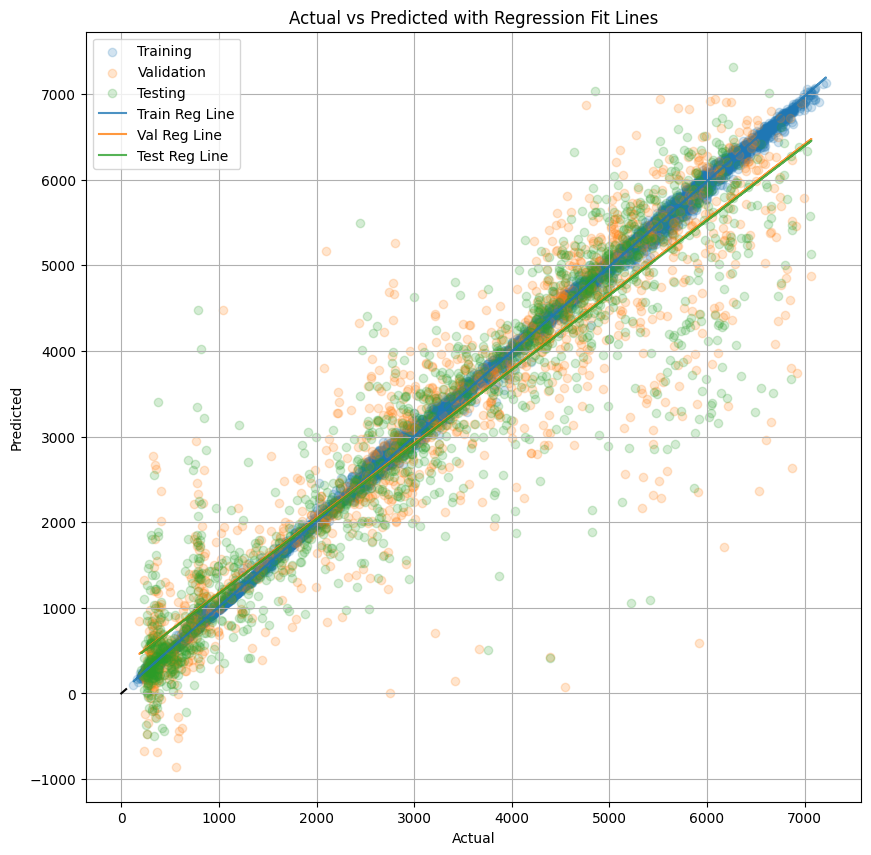

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(np.array([0, 50]),np.array([0, 50]),color='k',label='_nolegend_')
plt.scatter(y_train, y_train_pred, alpha=0.2, label="Training")
plt.scatter(y_val, y_val_pred, alpha=0.2, label="Validation")
plt.scatter(y_test, y_test_pred, alpha=0.2, label="Testing")
plt.plot(y_train, np.poly1d(np.polyfit(y_train, y_train_pred, 1))(y_train), color='tab:blue', alpha=0.8, label="Train Reg Line")
plt.plot(y_val, np.poly1d(np.polyfit(y_val, y_val_pred, 1))(y_val),   color='tab:orange', alpha=0.8, label="Val Reg Line")
plt.plot(y_test, np.poly1d(np.polyfit(y_test, y_test_pred, 1))(y_test), color='tab:green', alpha=0.8, label="Test Reg Line")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Actual vs Predicted with Regression Fit Lines")
plt.legend()
plt.grid()
plt.show()

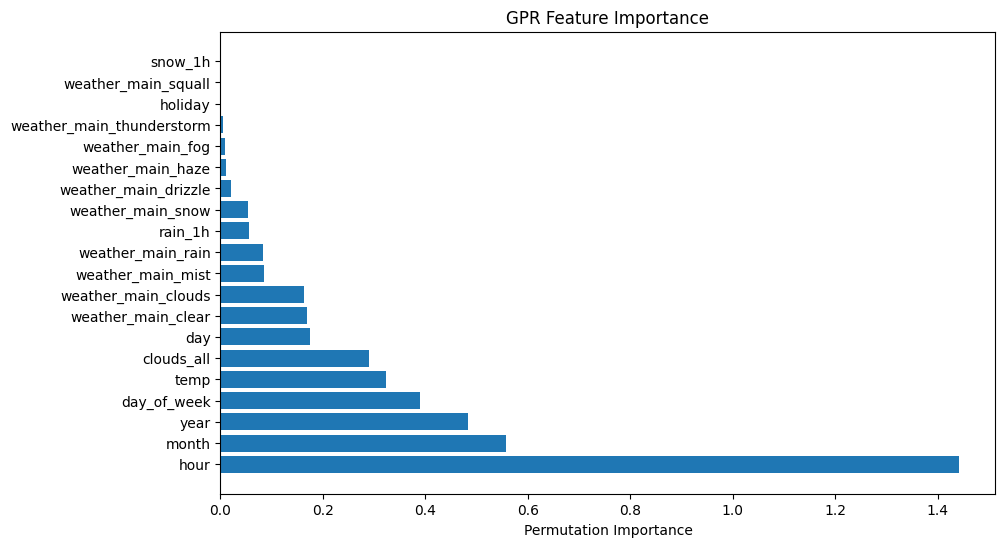

In [ ]:
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
feature_names = X_train.columns
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('GPR Feature Importance')
plt.show()